# 🏀 NBA Team Points Prediction Model 
📈 Basic Models Testing
---
🙋 **authors**: szymond44, gwiazdan  
📆 **date**: 21-07-2025  


In [1]:
import sys
import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score
from pytorch_tabnet.tab_model import TabNetRegressor
sys.path.append(os.path.abspath(os.path.join('..', 'src')))
%load_ext autoreload
%autoreload 2
from data import DataPreparation
%matplotlib inline

In [2]:
dp_lgl = DataPreparation(endpoint="leaguegamelog",starting_year=2019, ending_year=2025)
dp_bsa = DataPreparation(endpoint="boxscoreadvanced",starting_year=2019, ending_year=2025)
data_lgl = dp_lgl.dfs
data_bsa = dp_bsa.dfs

def rolling_avg(data):
    y_cols = ['home_pts', 'away_pts']
    train_df, val_df, test_df = data
    new_dfs = []
    for df in [train_df, val_df, test_df]:
        feature_cols = df.columns.difference(y_cols + ['date', 'home_team_id', 'away_team_id', 'game_id'])
        team_df = prepare_team_view(df, y_cols)
        team_df[feature_cols] = (
            team_df.groupby("team_id")[feature_cols]
                .transform(lambda x: x.shift(1).rolling(5, min_periods=1).mean())
        )
        team_df.dropna(inplace=True)
        new_dfs.append(team_df)
    return tuple(new_dfs)

def scale_data(data):
    y_cols = ['home_pts', 'away_pts']
    train_df, val_df, test_df = data
    scaler = StandardScaler()
    X_train = train_df.drop(columns=y_cols)
    y_train = train_df[y_cols]
    X_val = val_df.drop(columns=y_cols)
    y_val = val_df[y_cols]
    X_test = test_df.drop(columns=y_cols)
    y_test = test_df[y_cols]

    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    return (X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test)

def prepare_team_view(df, y_cols):
    home = df.copy()
    home["team_id"] = home["home_team_id"]
    home["opponent_id"] = home["away_team_id"]
    home["is_home"] = 1
    home_y = home[y_cols[0]]  # home_pts

    away = df.copy()
    away["team_id"] = away["away_team_id"]
    away["opponent_id"] = away["home_team_id"]
    away["is_home"] = 0
    away_y = away[y_cols[1]]  # away_pts

    team_df = pd.concat([home.assign(points=home_y), 
                         away.assign(points=away_y)], 
                        ignore_index=True)

    team_df = team_df.sort_values(["team_id", "date"])
    team_df = team_df.drop(columns=['date'])
    return team_df

data_lgl = rolling_avg(data_lgl)
data_bsa = rolling_avg(data_bsa)
data_lgl = scale_data(data_lgl)
data_bsa = scale_data(data_bsa)

In [3]:
def analyze_model(model, X_val, y_val, X_test, y_test):
    y_pred = model.predict(X_val)
    print("Validation R^2:", model.score(X_val, y_val))
    y_pred = model.predict(X_test)
    mse = ((y_test - y_pred) ** 2).mean()
    mae = (abs(y_test - y_pred)).mean()
    rmse = mse ** 0.5
    metrics = pd.DataFrame({
        "R^2": model.score(X_test, y_test),
        "MSE": mse,
        "MAE": mae,
        "RMSE": rmse
    }, index=["home_pts", "away_pts"]).round(2)
    print("Test metrics:")
    print(metrics)

    # Histogram błędów
    plt.figure(figsize=(12, 5))
    errors_home = y_test['home_pts'].values - y_pred[:, 0]
    errors_away = y_test['away_pts'].values - y_pred[:, 1]
    sns.histplot(errors_home, bins=50, color='blue', label='Home Error', kde=True)
    sns.histplot(errors_away, bins=50, color='orange', label='Away Error', kde=True)
    plt.title("Histogram of Prediction Errors")
    plt.xlabel("Error (True - Predicted)")
    plt.legend()
    plt.show()

    # Scatter: True vs Predicted
    plt.figure(figsize=(8, 8))
    plt.scatter(y_test['home_pts'].values, y_pred[:, 0], alpha=0.5, color='blue', label='Home')
    plt.scatter(y_test['away_pts'].values, y_pred[:, 1], alpha=0.5, color='orange', label='Away')
    plt.plot([80, 160], [80, 160], 'k--', lw=2)  # ideal line
    plt.xlabel("True Points")
    plt.ylabel("Predicted Points")
    plt.title("True vs Predicted Points")
    plt.legend()
    plt.show()

def analyze_catboost(models, X_val, y_val, X_test, y_test):
    # models: dict z kluczami 'home_pts', 'away_pts'
    y_pred_val = np.column_stack([
        models['home_pts'].predict(X_val),
        models['away_pts'].predict(X_val)
    ])
    y_pred = np.column_stack([
        models['home_pts'].predict(X_test),
        models['away_pts'].predict(X_test)
    ])

    # R^2 dla każdej kolumny
    r2_home = models['home_pts'].score(X_test, y_test['home_pts'])
    r2_away = models['away_pts'].score(X_test, y_test['away_pts'])
    mse = ((y_test.values - y_pred) ** 2).mean(axis=0)
    mae = (np.abs(y_test.values - y_pred)).mean(axis=0)
    rmse = mse ** 0.5

    metrics = pd.DataFrame({
        "R^2": [r2_home, r2_away],
        "MSE": mse,
        "MAE": mae,
        "RMSE": rmse
    }, index=["home_pts", "away_pts"]).round(2)
    print("Test metrics:")
    print(metrics)

    # Histogram błędów
    plt.figure(figsize=(12, 5))
    errors_home = y_test['home_pts'].values - y_pred[:, 0]
    errors_away = y_test['away_pts'].values - y_pred[:, 1]
    sns.histplot(errors_home, bins=50, color='blue', label='Home Error', kde=True)
    sns.histplot(errors_away, bins=50, color='orange', label='Away Error', kde=True)
    plt.title("Histogram of Prediction Errors (CatBoost)")
    plt.xlabel("Error (True - Predicted)")
    plt.legend()
    plt.show()

    # Scatter: True vs Predicted
    plt.figure(figsize=(8, 8))
    plt.scatter(y_test['home_pts'].values, y_pred[:, 0], alpha=0.5, color='blue', label='Home')
    plt.scatter(y_test['away_pts'].values, y_pred[:, 1], alpha=0.5, color='orange', label='Away')
    plt.plot([80, 160], [80, 160], 'k--', lw=2)
    plt.xlabel("True Points")
    plt.ylabel("Predicted Points")
    plt.title("True vs Predicted Points (CatBoost)")
    plt.legend()
    plt.show()

## Linear Models


**League Game log Data**

In [4]:
X_train, y_train, X_val, y_val, X_test, y_test = data_lgl
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(9844, 28) (9844, 2) (2086, 28) (2086, 2) (2088, 28) (2088, 2)


Linear Regression

Validation R^2: 0.38879432316247264
Test metrics:
           R^2     MSE   MAE   RMSE
home_pts  0.37  103.17  7.23  10.16
away_pts  0.37  103.49  7.21  10.17


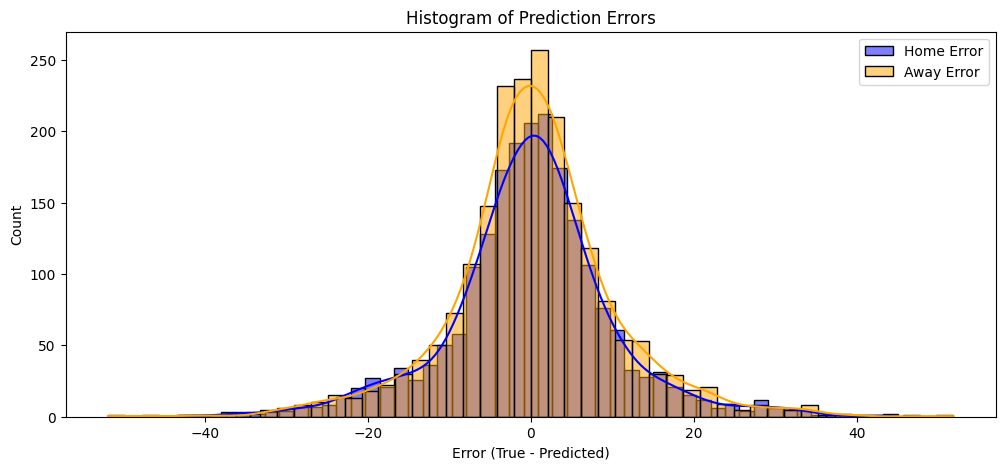

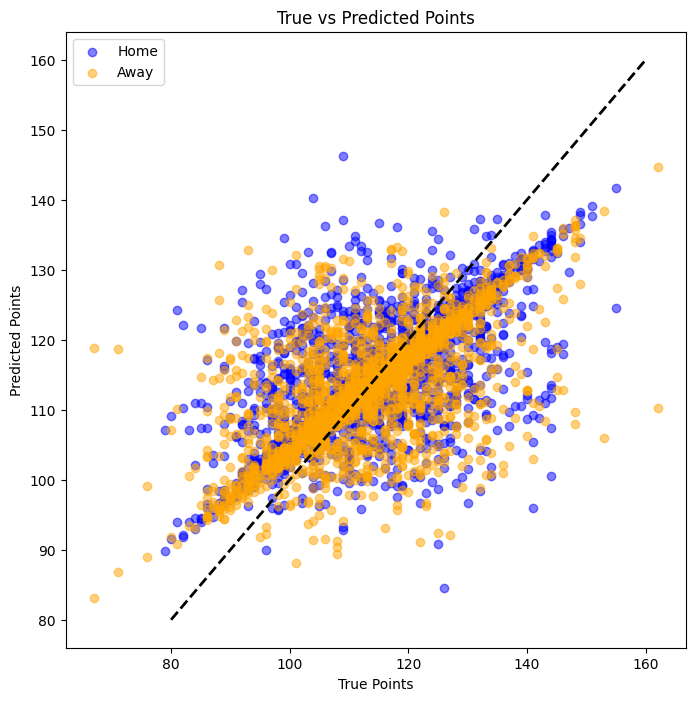

In [5]:
model = LinearRegression()
model.fit(X_train, y_train)
analyze_model(model, X_val, y_val, X_test, y_test)

Ridge Regression

Validation R^2: 0.38934178885006787
Test metrics:
           R^2     MSE   MAE   RMSE
home_pts  0.37  103.03  7.25  10.15
away_pts  0.37  103.40  7.23  10.17


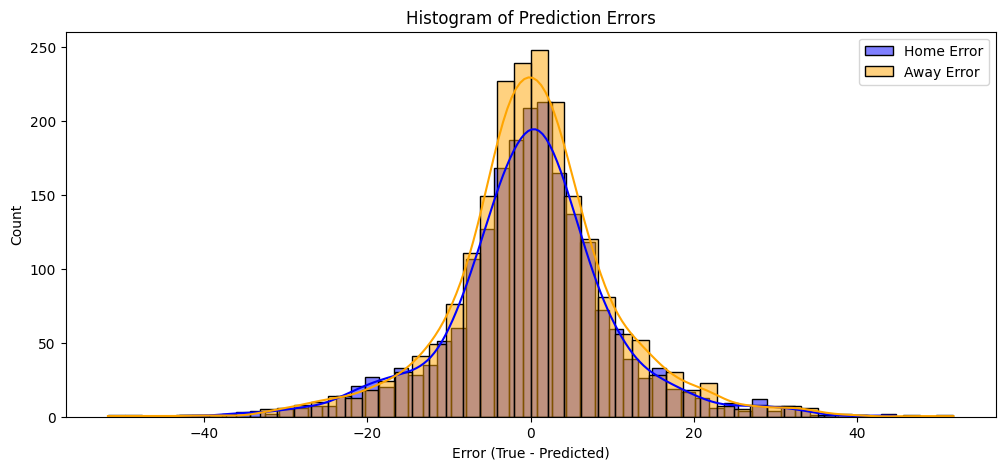

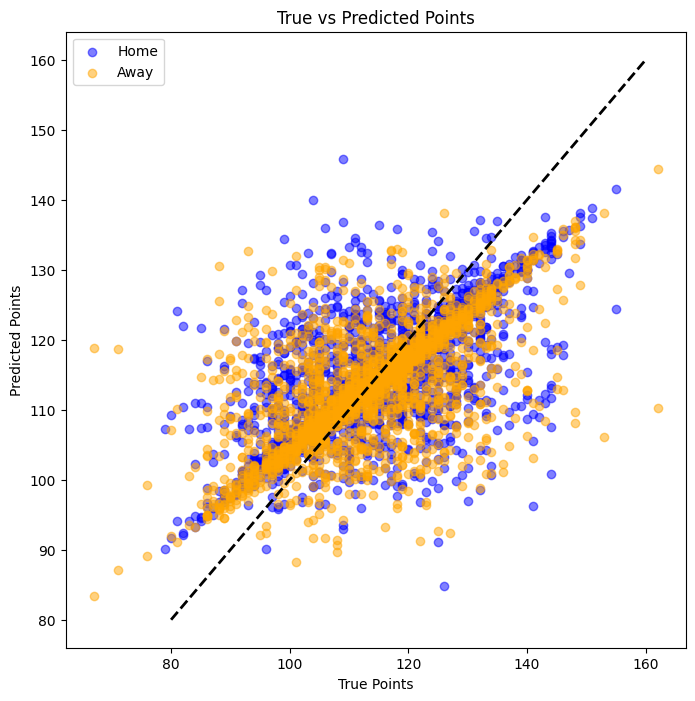

In [6]:
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}
ridge = Ridge()
grid = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)
model = grid.best_estimator_
analyze_model(model, X_val, y_val, X_test, y_test)

Validation R^2: 0.38686813219169924
Test metrics:
           R^2     MSE   MAE   RMSE
home_pts  0.37  103.39  7.25  10.17
away_pts  0.37  103.97  7.24  10.20


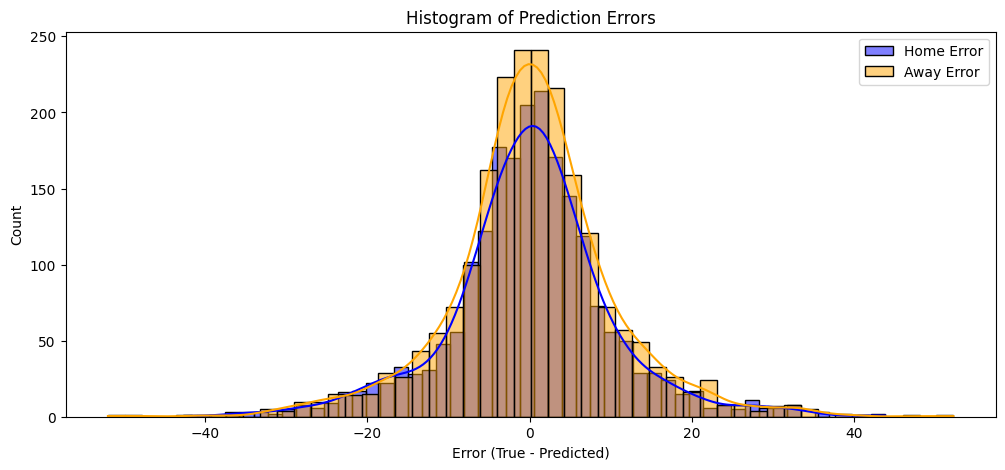

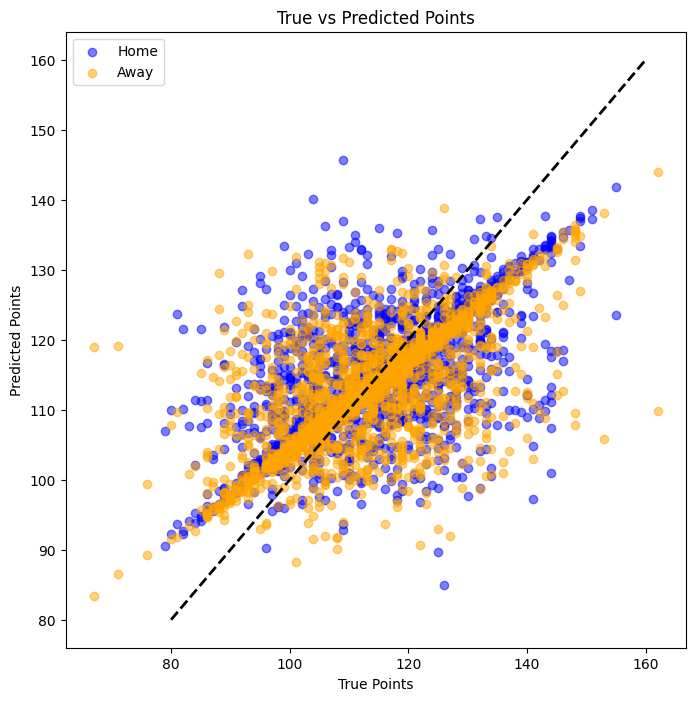

In [7]:
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}
lasso = Lasso()
grid = GridSearchCV(lasso, param_grid, cv=5, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)
model = grid.best_estimator_
analyze_model(model, X_val, y_val, X_test, y_test)

Validation R^2: 0.38686813219169924
Test metrics:
           R^2     MSE   MAE   RMSE
home_pts  0.37  103.39  7.25  10.17
away_pts  0.37  103.97  7.24  10.20


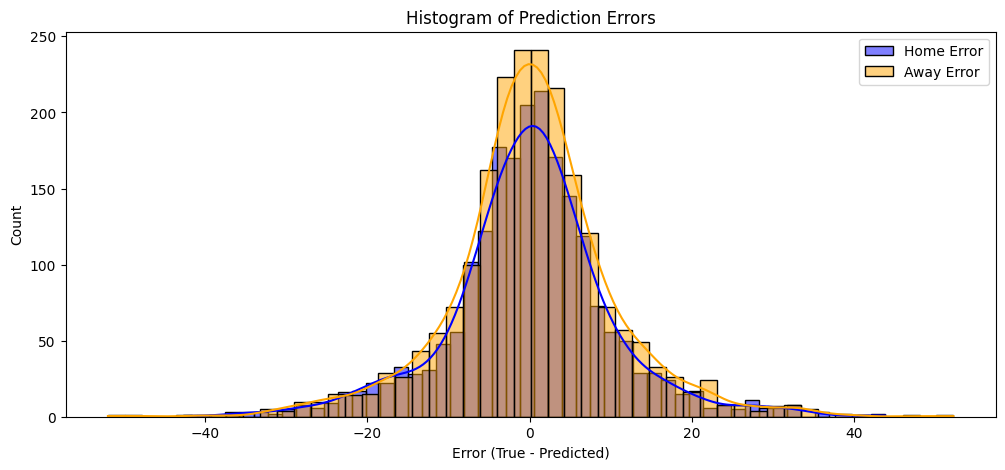

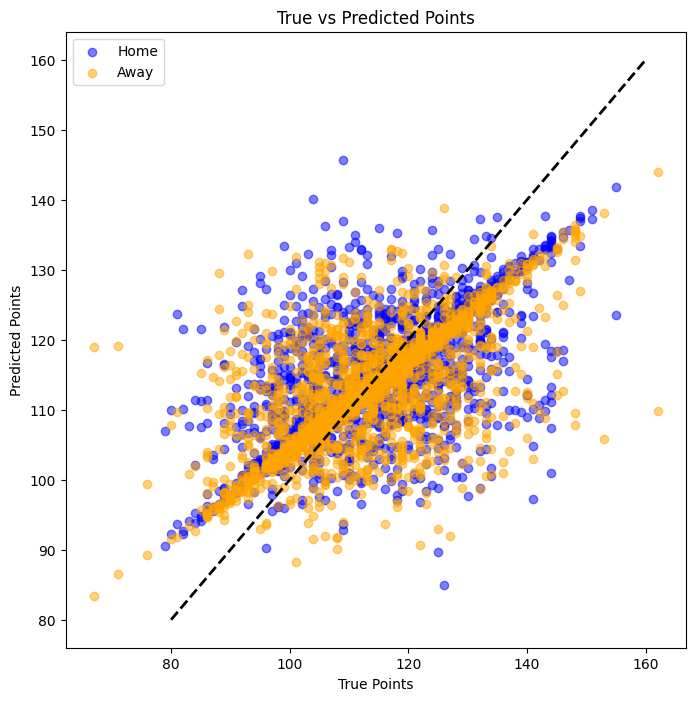

In [8]:
param_grid = {
    'alpha': [0.01, 0.1, 1, 10, 100],
    'l1_ratio': [0.1, 0.5, 0.7, 0.9, 1.0]
}
elastic = ElasticNet(max_iter=5000)
grid = GridSearchCV(elastic, param_grid, cv=5, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)
model = grid.best_estimator_
analyze_model(model, X_val, y_val, X_test, y_test)

**Box Score Advanced Data**

In [9]:
X_train, y_train, X_val, y_val, X_test, y_test = data_bsa
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(9844, 23) (9844, 2) (2086, 23) (2086, 2) (2088, 23) (2088, 2)


Validation R^2: 0.3892994383966696
Test metrics:
           R^2     MSE   MAE   RMSE
home_pts  0.37  103.16  7.22  10.16
away_pts  0.37  103.42  7.22  10.17


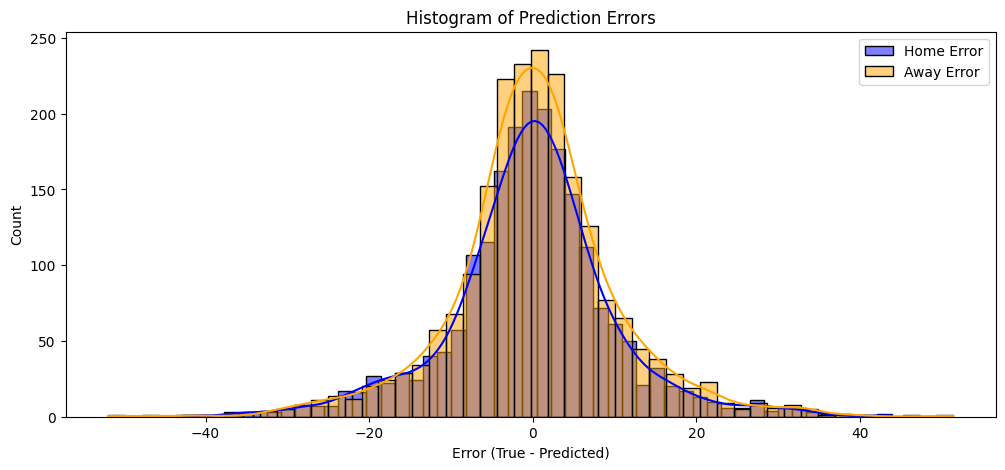

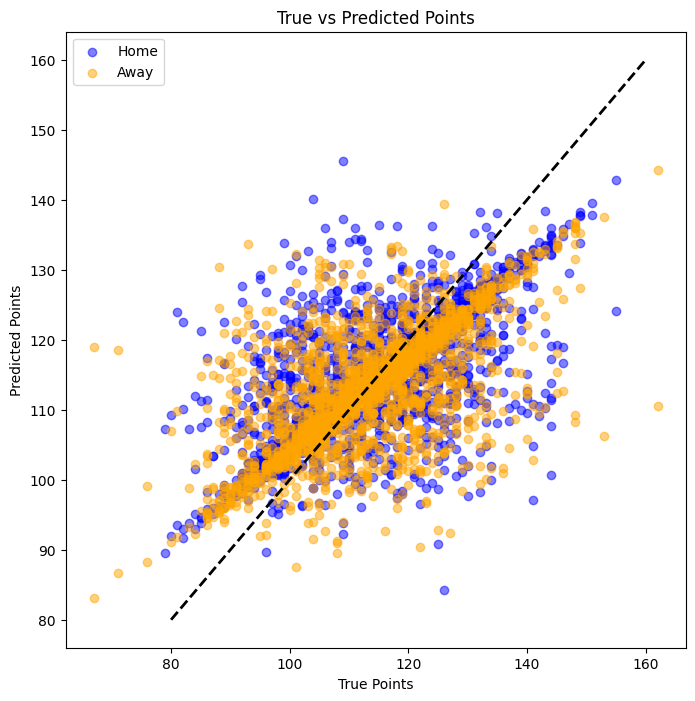

In [10]:
model = LinearRegression()
model.fit(X_train, y_train)
analyze_model(model, X_val, y_val, X_test, y_test)

Validation R^2: 0.38959921808825976
Test metrics:
           R^2     MSE   MAE   RMSE
home_pts  0.37  103.03  7.23  10.15
away_pts  0.37  103.37  7.23  10.17


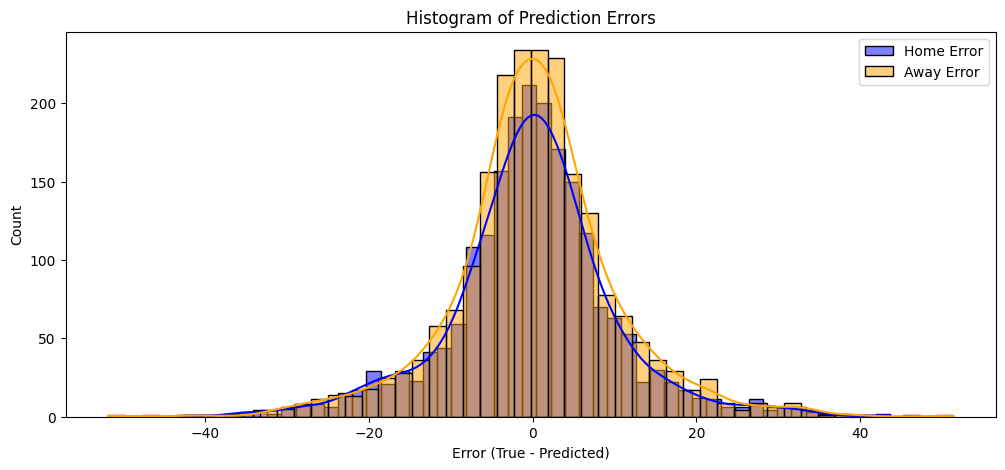

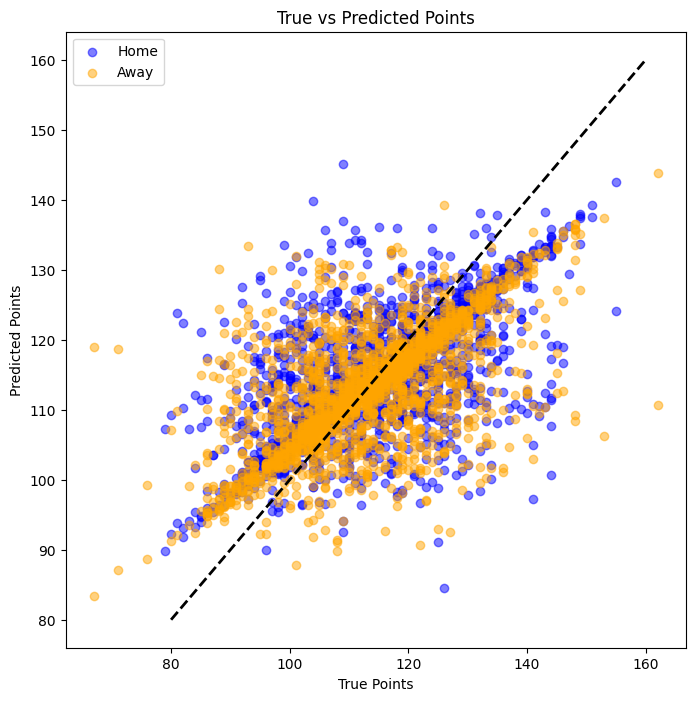

In [11]:
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}
ridge = Ridge()
grid = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train);
analyze_model(grid.best_estimator_, X_val, y_val, X_test, y_test)  

Validation R^2: 0.38726388103304665
Test metrics:
           R^2     MSE   MAE   RMSE
home_pts  0.37  103.26  7.25  10.16
away_pts  0.37  103.98  7.24  10.20


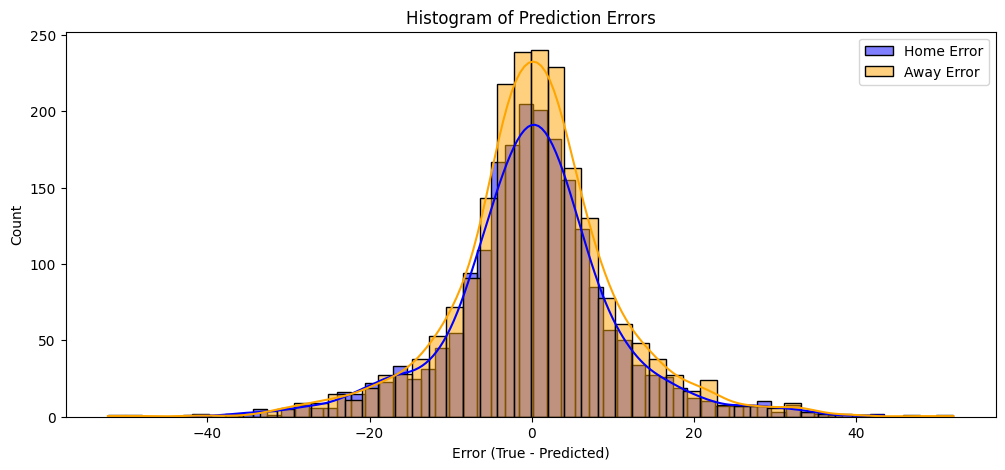

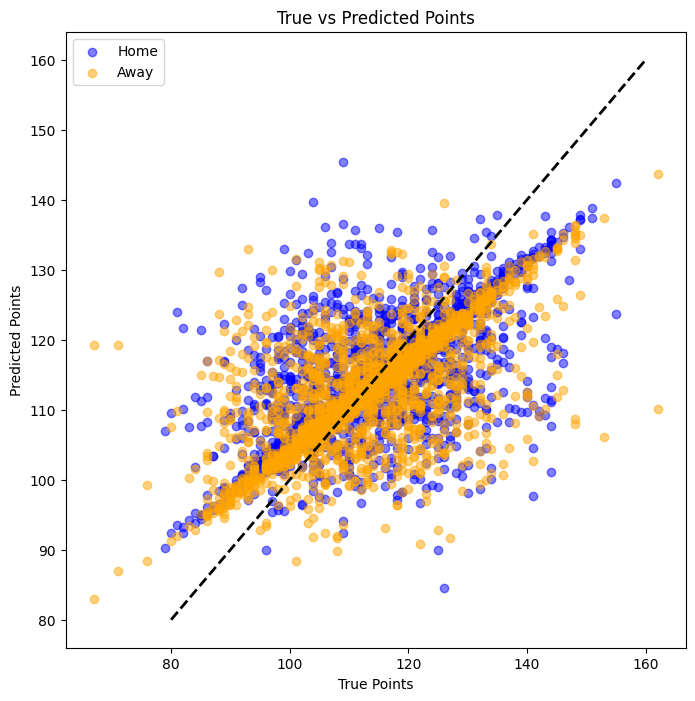

In [12]:
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}
lasso = Lasso()
grid = GridSearchCV(lasso, param_grid, cv=5, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train);
analyze_model(grid.best_estimator_, X_val, y_val, X_test, y_test)

Validation R^2: 0.38726388103304665
Test metrics:
           R^2     MSE   MAE   RMSE
home_pts  0.37  103.26  7.25  10.16
away_pts  0.37  103.98  7.24  10.20


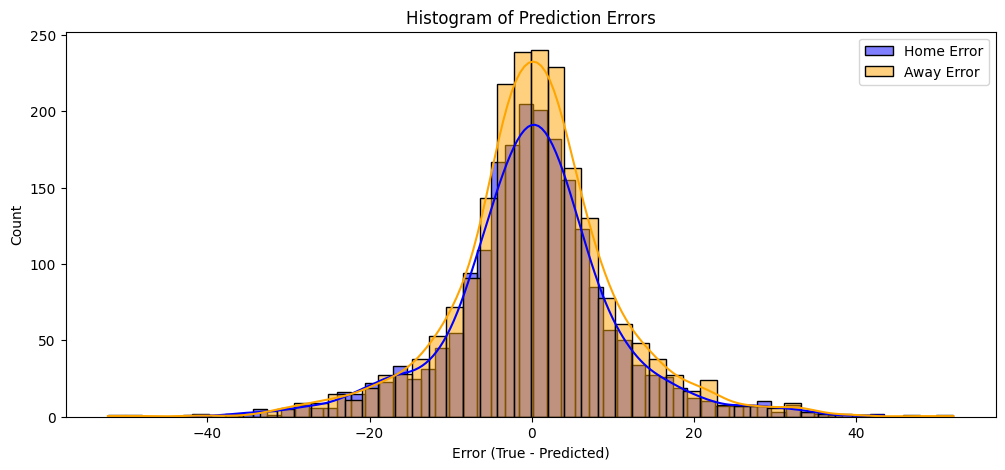

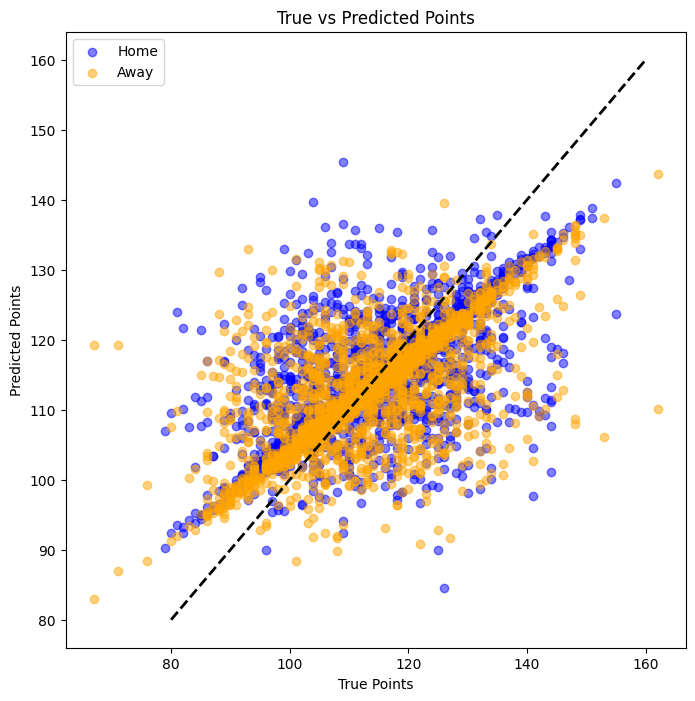

In [13]:
param_grid = {
    'alpha': [0.01, 0.1, 1, 10, 100],
    'l1_ratio': [0.1, 0.5, 0.7, 0.9, 1.0]
}
elastic = ElasticNet(max_iter=5000)
grid = GridSearchCV(elastic, param_grid, cv=5, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train);
analyze_model(grid.best_estimator_, X_val, y_val, X_test, y_test)

## Nonlinear regression

**League Game log Data**


In [14]:
X_train, y_train, X_val, y_val, X_test, y_test = data_lgl

Validation R^2: 0.32115247561656973
Test metrics:
           R^2     MSE   MAE   RMSE
home_pts  0.31  112.35  8.23  10.60
away_pts  0.31  114.34  8.25  10.69


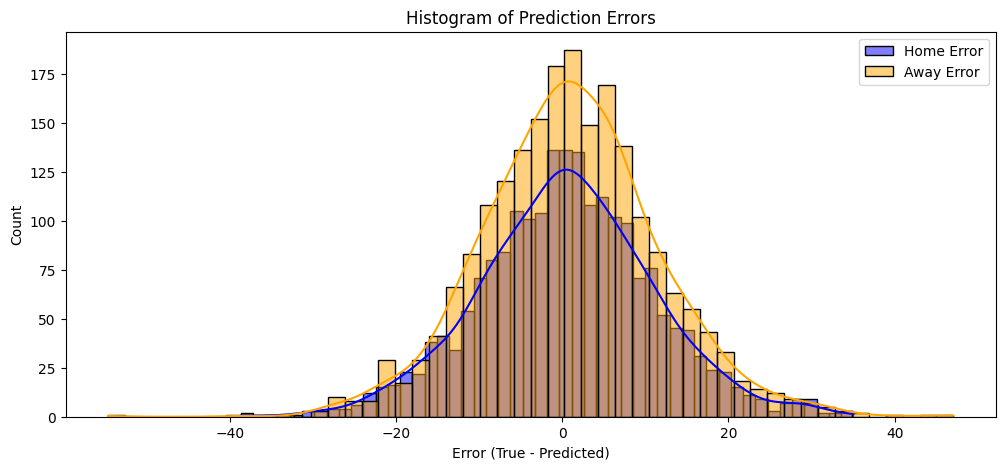

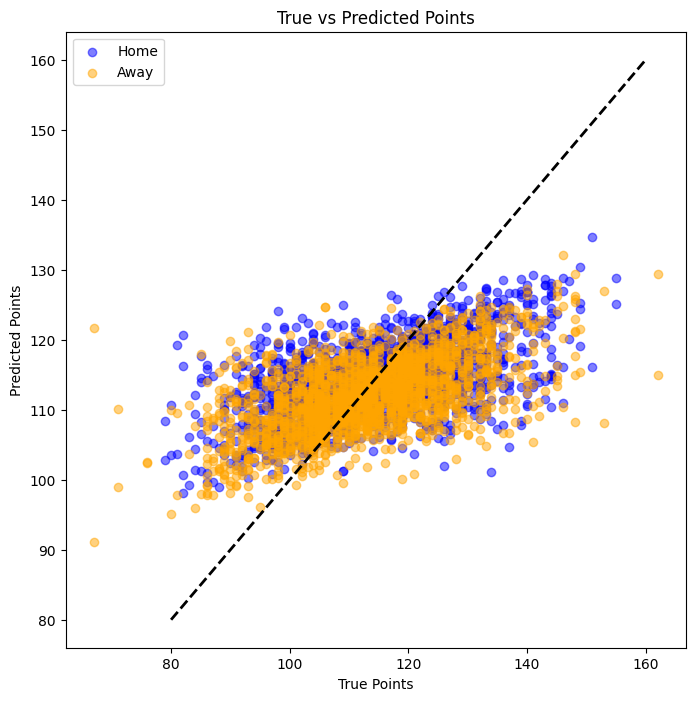

In [15]:
param_grid = {
    'n_neighbors': [3, 5, 7, 10, 15],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # 1: Manhattan, 2: Euclidean
}
knn = KNeighborsRegressor()
grid = GridSearchCV(knn, param_grid, cv=5, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)
analyze_model(grid.best_estimator_, X_val, y_val, X_test, y_test)

Validation R^2: 0.5335294008255005
Test metrics:
           R^2    MSE   MAE  RMSE
home_pts  0.52  78.18  5.29  8.84
away_pts  0.52  80.63  5.30  8.98


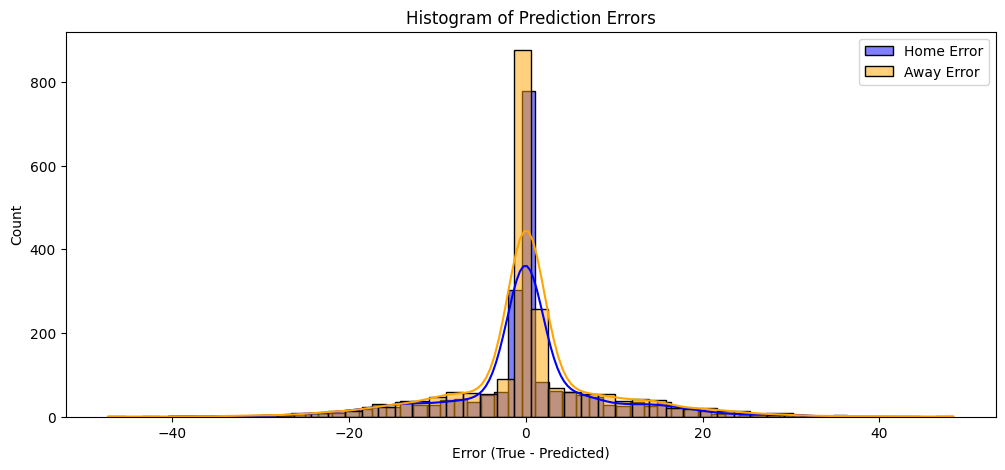

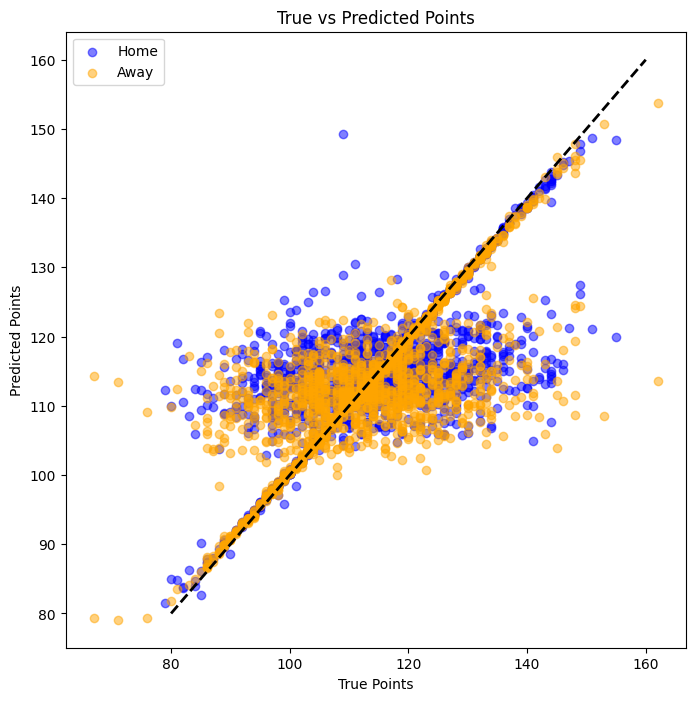

In [16]:
param_grid = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7]
}
xgb = XGBRegressor(tree_method='hist', verbosity=0)
grid = GridSearchCV(xgb, param_grid, cv=5, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)
analyze_model(grid.best_estimator_, X_val, y_val, X_test, y_test)

Validation R^2: 0.5213094492732562
Test metrics:
          R^2    MSE   MAE  RMSE
home_pts  0.5  83.70  5.74  9.15
away_pts  0.5  80.57  5.56  8.98


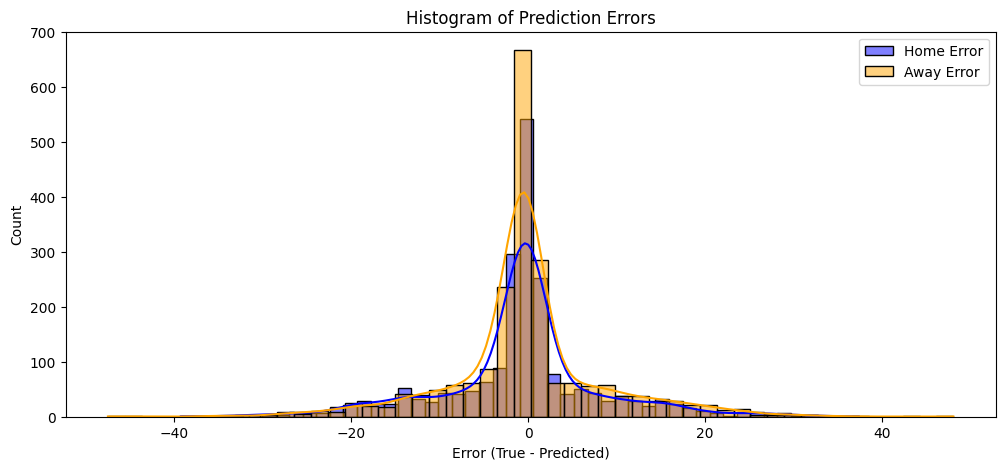

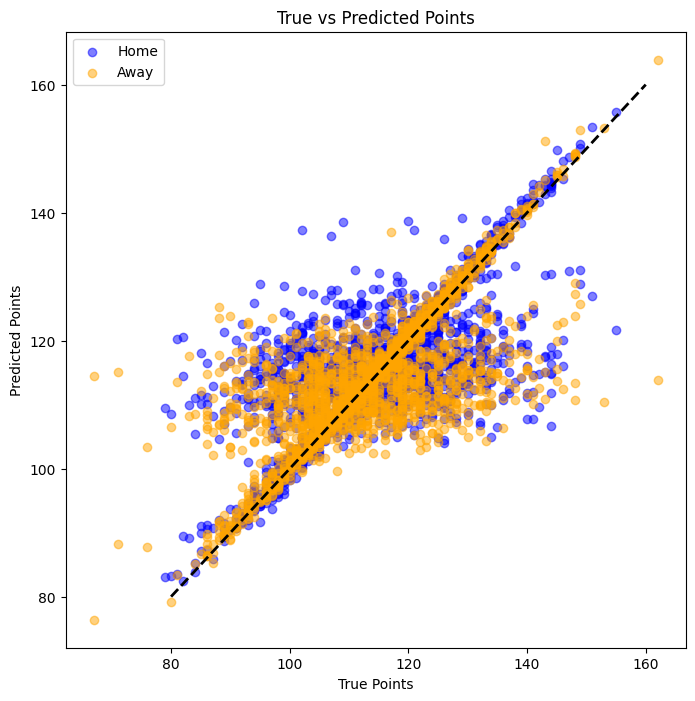

In [17]:
param_grid = {
    'hidden_layer_sizes': [(64, 32), (128, 64), (256, 128), (128, 128)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'learning_rate_init': [0.001, 0.005, 0.01],
    'max_iter': [500, 1000]
}

mlp = MLPRegressor(solver='adam', random_state=42, early_stopping=True)
grid = GridSearchCV(mlp, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=4)
grid.fit(X_train, y_train)
analyze_model(grid.best_estimator_, X_val, y_val, X_test, y_test)

Test metrics:
           R^2    MSE   MAE  RMSE
home_pts  0.52  78.04  5.32  8.83
away_pts  0.52  78.60  5.23  8.87


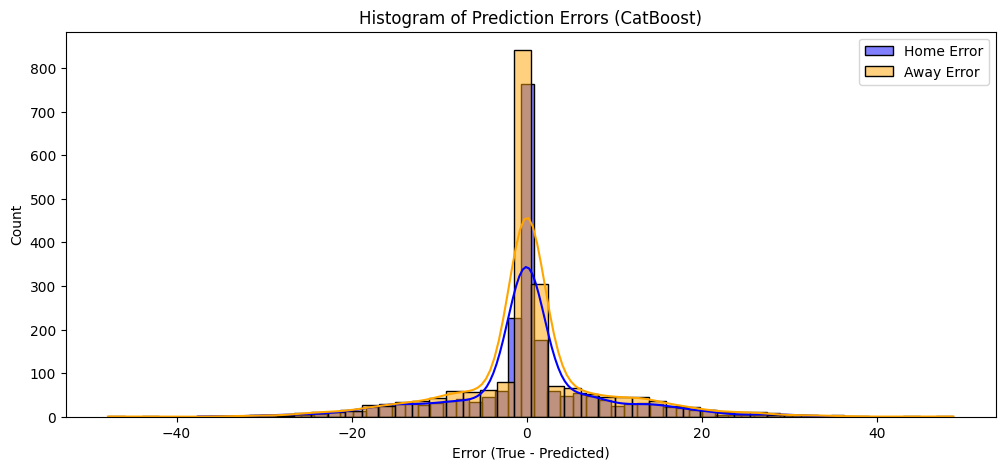

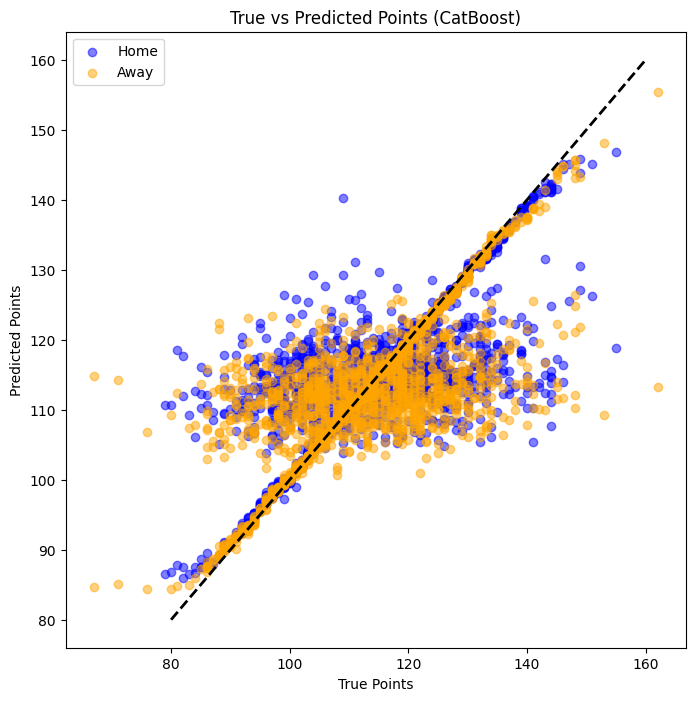

In [18]:
param_grid = {
    'iterations': [500, 1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [3, 5, 7]
}

models = {}
y_pred_val = []
y_pred_test = []

for col in ['home_pts', 'away_pts']:
    cat = CatBoostRegressor(verbose=0, random_state=42)
    grid = GridSearchCV(cat, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
    grid.fit(X_train, y_train[col])
    models[col] = grid.best_estimator_
    y_pred_val.append(models[col].predict(X_val))
    y_pred_test.append(models[col].predict(X_test))

y_pred_val = np.column_stack(y_pred_val)
y_pred_test = np.column_stack(y_pred_test)
analyze_catboost(models, X_val, y_val, X_test, y_test)


In [19]:
def analyze_tabnet(tabnet, X_val, y_val, X_test, y_test):
    y_pred_val = tabnet.predict(X_val)
    y_pred = tabnet.predict(X_test)
    
    print("Validation R^2:", r2_score(y_val, y_pred_val, multioutput='raw_values'))
    mse = ((y_test - y_pred) ** 2).mean(axis=0)
    mae = (abs(y_test - y_pred)).mean(axis=0)
    rmse = mse ** 0.5
    metrics = pd.DataFrame({
        "R^2": r2_score(y_test, y_pred, multioutput='raw_values'),
        "MSE": mse,
        "MAE": mae,
        "RMSE": rmse
    }, index=["home_pts", "away_pts"]).round(2)
    print("Test metrics:")
    print(metrics)

    # Histogram błędów
    plt.figure(figsize=(12, 5))
    errors_home = y_test[:, 0] - y_pred[:, 0]
    errors_away = y_test[:, 1] - y_pred[:, 1]
    sns.histplot(errors_home, bins=50, color='blue', label='Home Error', kde=True)
    sns.histplot(errors_away, bins=50, color='orange', label='Away Error', kde=True)
    plt.title("Histogram of Prediction Errors (TabNet)")
    plt.xlabel("Error (True - Predicted)")
    plt.legend()
    plt.show()

    # Scatter: True vs Predicted
    plt.figure(figsize=(8, 8))
    plt.scatter(y_test[:, 0], y_pred[:, 0], alpha=0.5, color='blue', label='Home')
    plt.scatter(y_test[:, 1], y_pred[:, 1], alpha=0.5, color='orange', label='Away')
    plt.plot([80, 160], [80, 160], 'k--', lw=2)
    plt.xlabel("True Points")
    plt.ylabel("Predicted Points")
    plt.title("True vs Predicted Points (TabNet)")
    plt.legend()
    plt.show()


Early stopping occurred at epoch 148 with best_epoch = 98 and best_val_0_mse = 78.19273
Validation R^2: [0.5321752  0.51194334]
Test metrics:
           R^2    MSE   MAE  RMSE
home_pts  0.52  77.74  5.42  8.82
away_pts  0.50  81.63  5.64  9.03


d:\Projekty\ML\model\.venv\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
d:\Projekty\ML\model\.venv\Lib\site-packages\torch\utils\data\_utils\collate.py:285: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_numpy.cpp:209.)
  return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


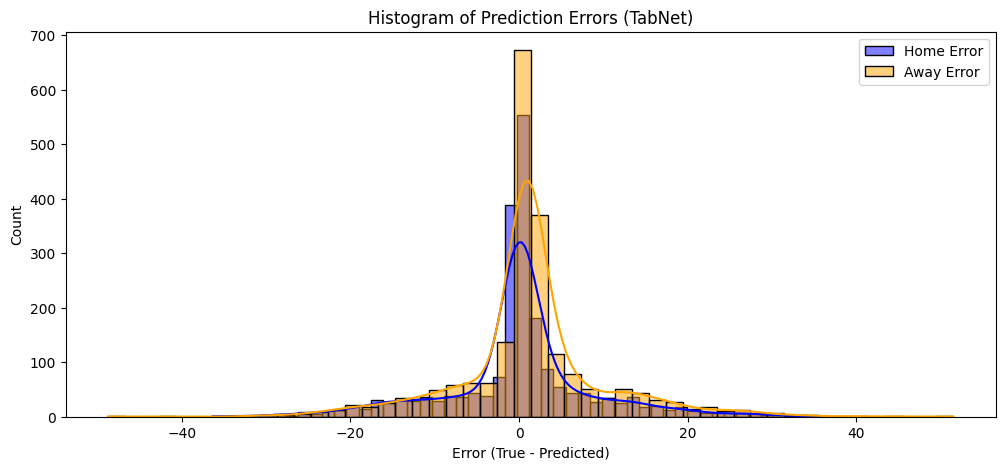

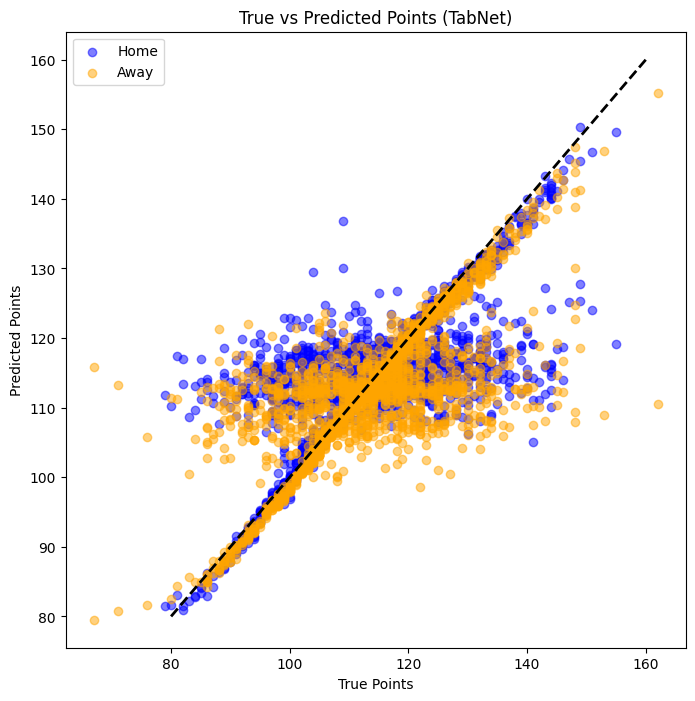

In [20]:
X_train_np = X_train if isinstance(X_train, np.ndarray) else X_train.values
y_train_np = y_train.values
X_val_np = X_val if isinstance(X_val, np.ndarray) else X_val.values
y_val_np = y_val.values
X_test_np = X_test if isinstance(X_test, np.ndarray) else X_test.values
y_test_np = y_test.values

tabnet = TabNetRegressor(verbose=0, seed=42)
tabnet.fit(
    X_train_np, y_train_np,
    eval_set=[(X_val_np, y_val_np)],
    patience=50,
    max_epochs=200
)

analyze_tabnet(tabnet, X_val_np, y_val_np, X_test_np, y_test_np)

**Box Score Advanced Data**

In [21]:
X_train, y_train, X_val, y_val, X_test, y_test = data_bsa

Validation R^2: 0.35088033571339794
Test metrics:
           R^2     MSE   MAE   RMSE
home_pts  0.34  106.62  7.93  10.33
away_pts  0.34  110.93  8.01  10.53


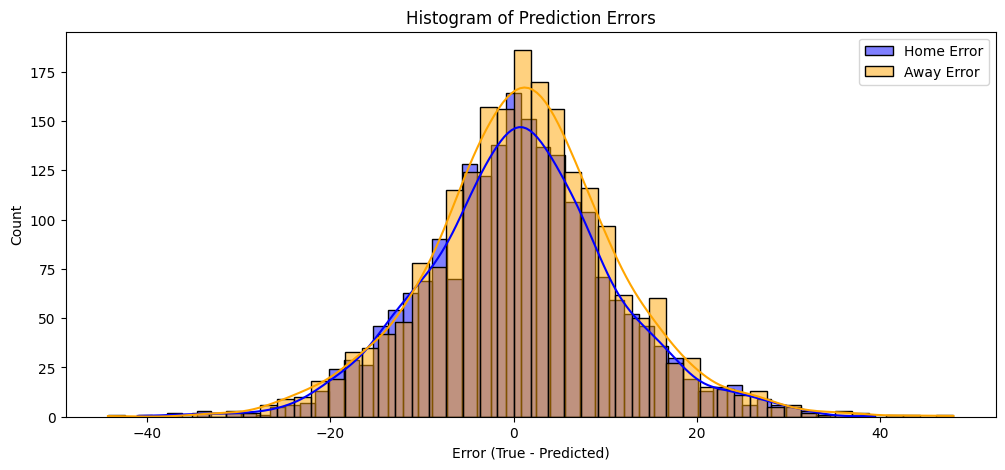

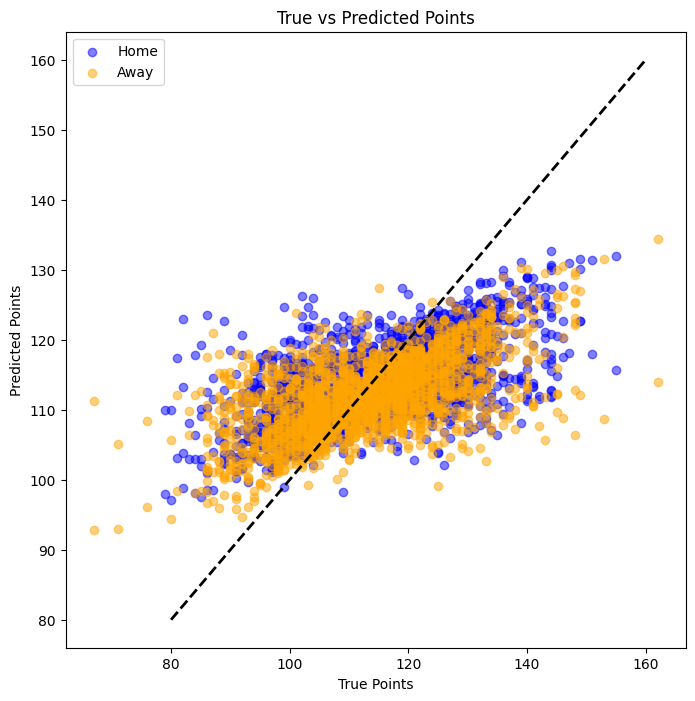

In [22]:
param_grid = {
    'n_neighbors': [3, 5, 7, 10, 15],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # 1: Manhattan, 2: Euclidean
}
knn = KNeighborsRegressor()
grid = GridSearchCV(knn, param_grid, cv=5, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train);
analyze_model(grid.best_estimator_, X_val, y_val, X_test, y_test)

Validation R^2: 0.5327754616737366
Test metrics:
           R^2    MSE   MAE  RMSE
home_pts  0.52  78.98  5.44  8.89
away_pts  0.52  79.83  5.47  8.93


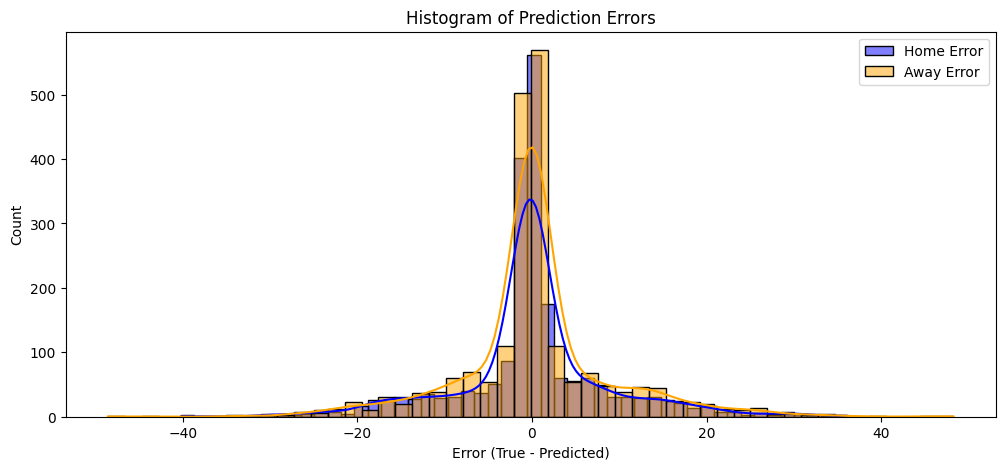

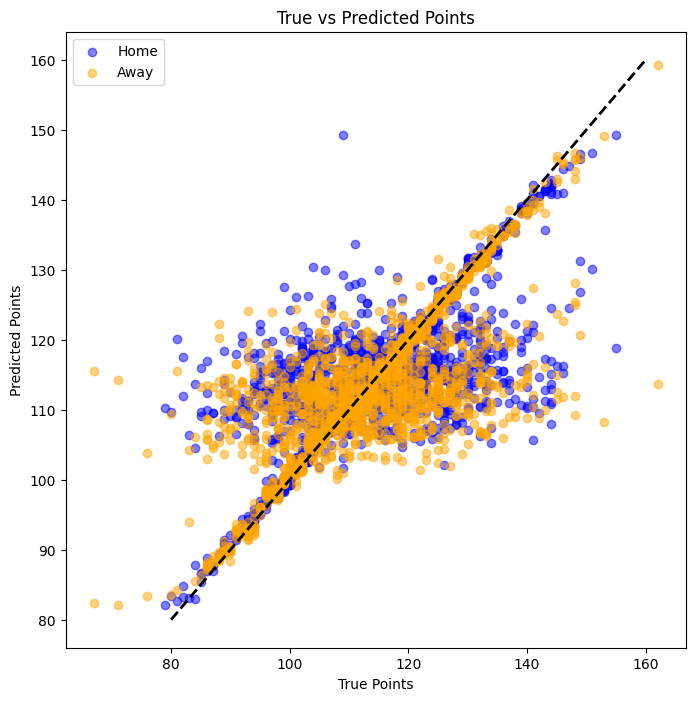

In [23]:
param_grid = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7]
}
xgb = XGBRegressor(tree_method='hist', verbosity=0)
grid = GridSearchCV(xgb, param_grid, cv=5, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train);
analyze_model(grid.best_estimator_, X_val, y_val, X_test, y_test)

Validation R^2: 0.5185936688982526
Test metrics:
          R^2    MSE   MAE  RMSE
home_pts  0.5  81.99  5.93  9.05
away_pts  0.5  81.43  5.57  9.02


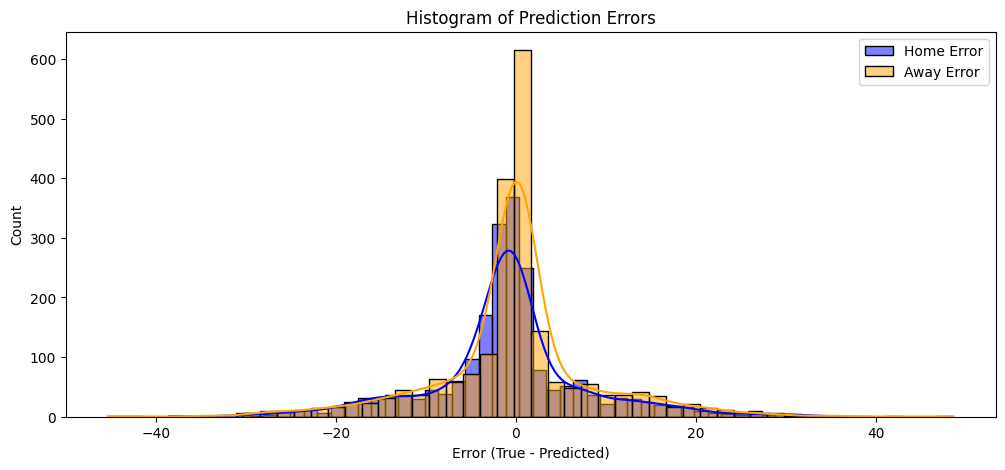

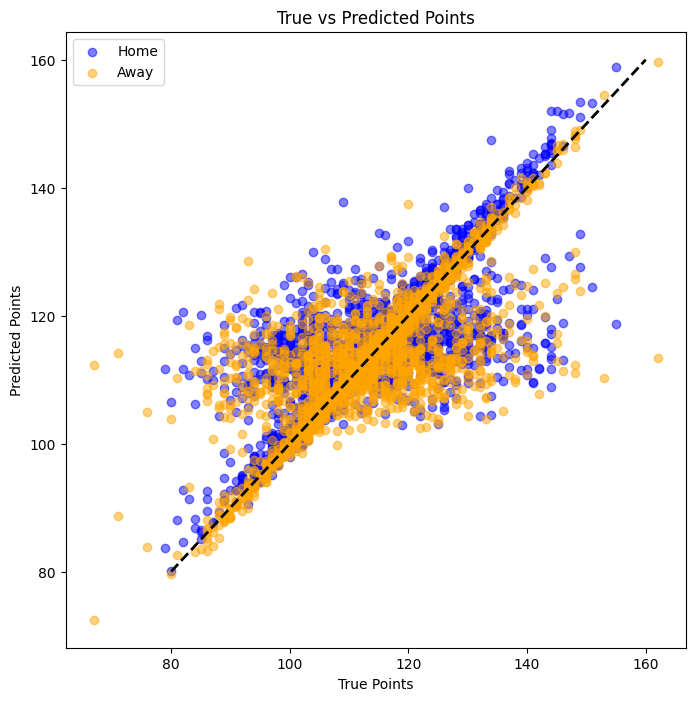

In [24]:
param_grid = {
    'hidden_layer_sizes': [(64, 32), (128, 64), (256, 128), (128, 128)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'learning_rate_init': [0.001, 0.005, 0.01],
    'max_iter': [500, 1000]
}

mlp = MLPRegressor(solver='adam', random_state=42, early_stopping=True)
grid = GridSearchCV(mlp, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=4)
grid.fit(X_train, y_train);
analyze_model(grid.best_estimator_, X_val, y_val, X_test, y_test)

Test metrics:
           R^2    MSE   MAE  RMSE
home_pts  0.53  76.81  5.23  8.76
away_pts  0.52  78.51  5.23  8.86


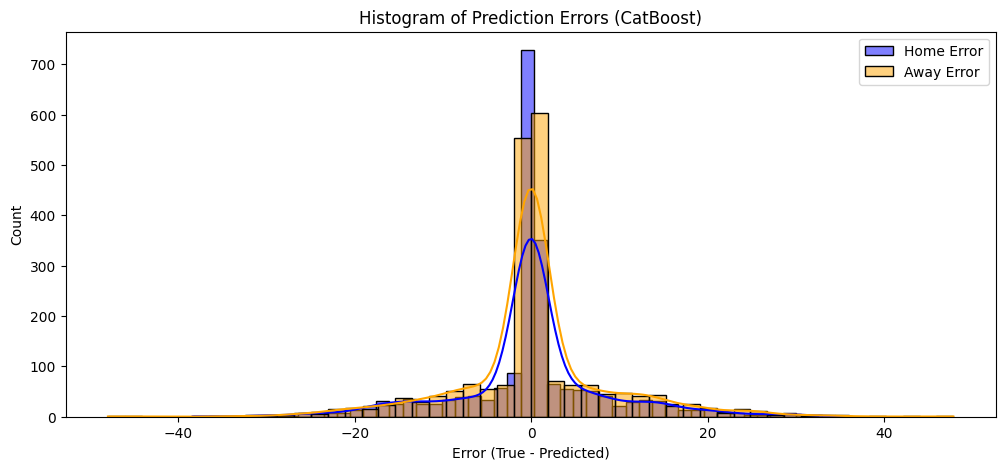

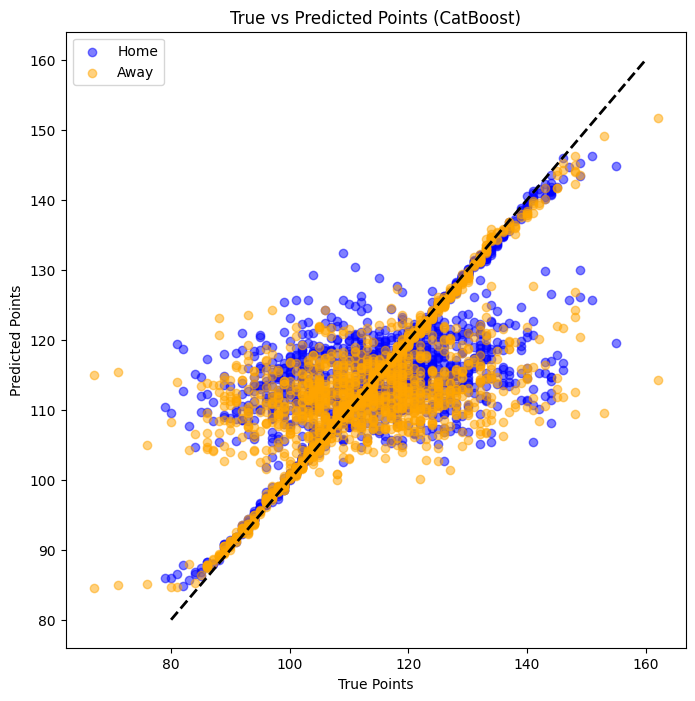

In [25]:
param_grid = {
    'iterations': [500, 1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [3, 5, 7]
}

models = {}
y_pred_val = []
y_pred_test = []

for col in ['home_pts', 'away_pts']:
    cat = CatBoostRegressor(verbose=0, random_state=42)
    grid = GridSearchCV(cat, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
    grid.fit(X_train, y_train[col])
    models[col] = grid.best_estimator_
    y_pred_val.append(models[col].predict(X_val))
    y_pred_test.append(models[col].predict(X_test))

y_pred_val = np.column_stack(y_pred_val)
y_pred_test = np.column_stack(y_pred_test)
analyze_catboost(models, X_val, y_val, X_test, y_test)


Early stopping occurred at epoch 163 with best_epoch = 113 and best_val_0_mse = 76.64276


d:\Projekty\ML\model\.venv\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Validation R^2: [0.53461283 0.52837926]
Test metrics:
           R^2    MSE   MAE  RMSE
home_pts  0.53  77.34  5.27  8.79
away_pts  0.51  80.13  5.36  8.95


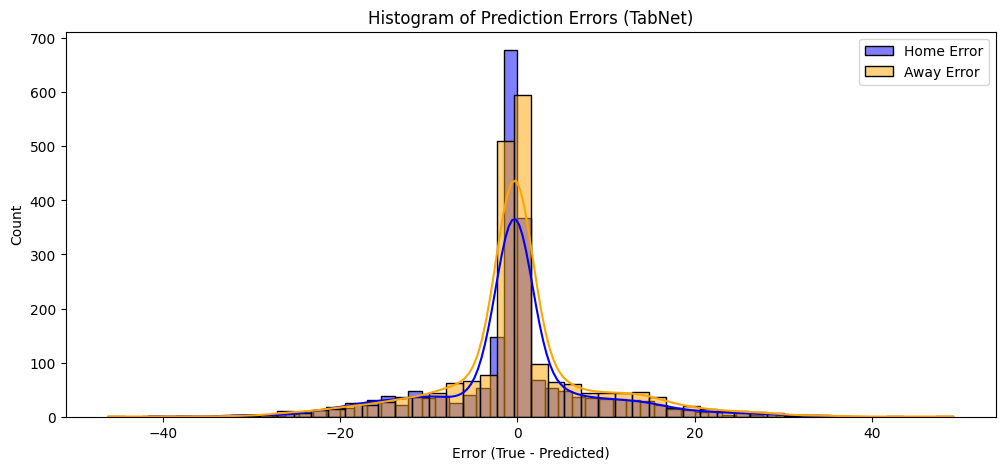

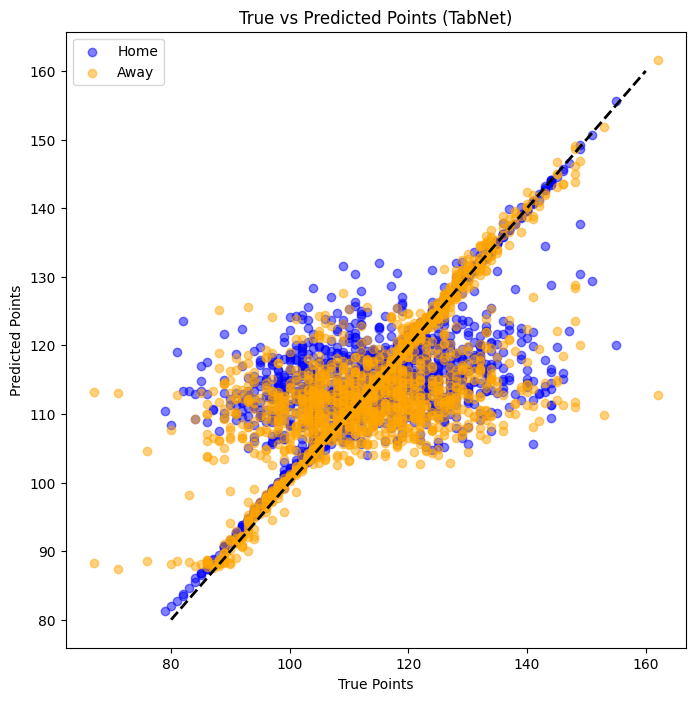

In [26]:
X_train_np = X_train if isinstance(X_train, np.ndarray) else X_train.values
y_train_np = y_train.values
X_val_np = X_val if isinstance(X_val, np.ndarray) else X_val.values
y_val_np = y_val.values
X_test_np = X_test if isinstance(X_test, np.ndarray) else X_test.values
y_test_np = y_test.values

tabnet = TabNetRegressor(verbose=0, seed=42)
tabnet.fit(
    X_train_np, y_train_np,
    eval_set=[(X_val_np, y_val_np)],
    patience=50,
    max_epochs=200
)

analyze_tabnet(tabnet, X_val_np, y_val_np, X_test_np, y_test_np)